In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight

from sklearn.metrics import classification_report, confusion_matrix
import zipfile, os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print(tf.__version__)


2.10.1


In [11]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Available GPUs:", len(gpus))
else:
    print("No GPUs available.")

Available GPUs: 1


In [12]:
base_dir = 'chest'
train_dir = 'chest/train'
test_dir = 'chest/test'
val_dir = 'chest/val'
os.listdir(base_dir)

['test', 'train', 'val']

In [13]:
img_width, img_height = 224, 224
batch_size = 128

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
)


Found 4204 images belonging to 2 classes.
Found 1052 images belonging to 2 classes.


In [14]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 2.0487329434697856, 1: 0.6614222781623663}

In [15]:
densenet201 = DenseNet201(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in densenet201.layers:
    layer.trainable = False

# x = densenet201.output
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
# pred = layers.Dense(1, activation='sigmoid')(x)

x = densenet201.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)
pred = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=densenet201.input, outputs=pred)

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-5, verbose=1)

model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_binary_accuracy', save_best_only=True, mode='max', verbose=1)

In [17]:
epochs=50

hist = model.fit(train_generator,
                 epochs=epochs,
                 validation_data=val_generator,
                 callbacks=[early_stopping, reduce_lr, model_checkpoint],
                 class_weight=class_weight_dict
)

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 5.2008 - binary_accuracy: 0.5202
Epoch 1: val_binary_accuracy improved from -inf to 0.64924, saving model to best_model.h5
33/33 [==============================] - 97s 2s/step - loss: 5.2008 - binary_accuracy: 0.5202 - val_loss: 5.1304 - val_binary_accuracy: 0.6492 - lr: 0.0010
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 5.1815 - binary_accuracy: 0.5557
Epoch 2: val_binary_accuracy improved from 0.64924 to 0.67395, saving model to best_model.h5
33/33 [==============================] - 73s 2s/step - loss: 5.1815 - binary_accuracy: 0.5557 - val_loss: 5.1142 - val_binary_accuracy: 0.6740 - lr: 0.0010
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 5.1506 - binary_accuracy: 0.5825
Epoch 3: val_binary_accuracy improved from 0.67395 to 0.69677, saving model to best_model.h5
33/33 [==============================] - 75s 2s/step - loss: 5.1506 - binary_accuracy: 0.5825 - val_loss: 5.0

In [18]:
test_loss, test_acc = model.evaluate(val_generator)
print(f'Test accuracy: {test_acc}')

9/9 [==============================] - 10s 970ms/step - loss: 4.7140 - binary_accuracy: 0.8137
Test accuracy: 0.8136882185935974


In [19]:
hist_= pd.DataFrame(hist.history)
hist_

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,5.200787,0.520219,5.130432,0.649240,0.001
1,5.181482,0.555661,5.114194,0.673954,0.001
2,5.150557,0.582540,5.098918,0.696768,0.001
3,5.145985,0.591342,5.084399,0.725285,0.001
4,5.140758,0.597050,5.074432,0.730989,0.001
5,5.113394,0.615842,5.061114,0.747148,0.001
6,5.108834,0.635347,5.052055,0.750951,0.001
7,5.101908,0.628449,5.040663,0.759506,0.001
8,5.085876,0.648430,5.030844,0.767110,0.001
9,5.073788,0.647716,5.018946,0.779468,0.001


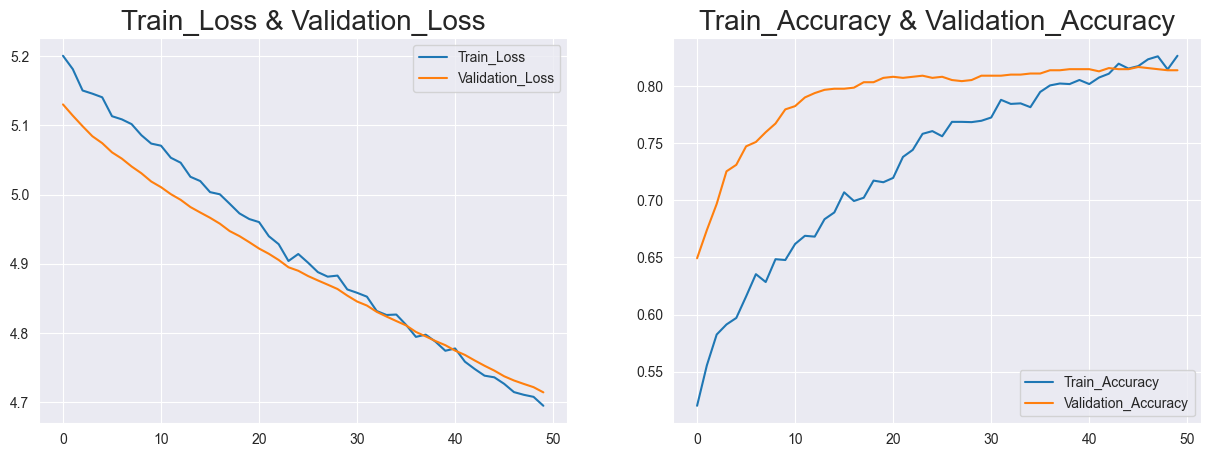

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['binary_accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_binary_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [21]:
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 600 images belonging to 2 classes.


In [22]:
y_pred = model.predict(test_generator)

5/5 [==============================] - 15s 2s/step


In [23]:
y_pred_binary = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

In [24]:
classification_rep = classification_report(y_true, y_pred_binary, target_names=['Normal', 'Pneumonia'])
confusion_mat = confusion_matrix(y_true, y_pred_binary)

print("Classification Report:\n", classification_rep)
print("\nConfusion Matrix:\n", confusion_mat)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.79      0.99      0.88       300
   Pneumonia       0.99      0.74      0.85       300

    accuracy                           0.87       600
   macro avg       0.89      0.87      0.86       600
weighted avg       0.89      0.87      0.86       600


Confusion Matrix:
 [[298   2]
 [ 78 222]]


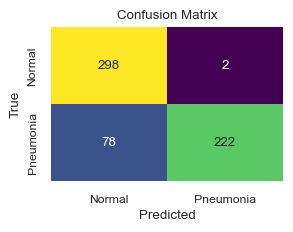

In [25]:
plt.figure(figsize=(3, 2))
sns.set(font_scale=0.8)
sns.heatmap(confusion_mat, annot=True, cmap='viridis', cbar=False, fmt='d', 
            xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
model.save('pneumonia_densenet201v3.h5')

1/1 [==============================] - 3s 3s/step
chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg
Image classified as Pneumonia
[0.9905077]


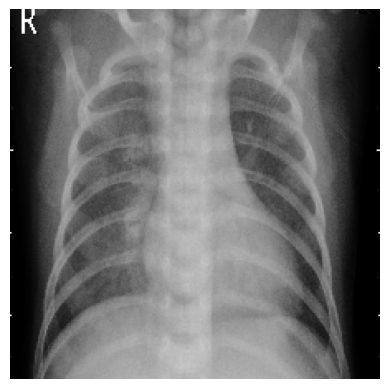

In [55]:
# uploaded = files.upload()

# for fn in uploaded.keys():
#   path = fn
img = image.load_img('chest/val/PNEUMONIA/person74_virus_135.jpeg', target_size=(224,224,3))

imgplot = plt.imshow(img)
plt.axis('off')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
images = np.vstack([x])

classes = model.predict(images)
print('chest_xray/val/PNEUMONIA/person1005_virus_1688.jpeg')
if classes[0] > 0.5:
  print('Image classified as Pneumonia')
else:
  print('Image classified as Normal')
print(classes[0])